In [12]:
import sys, os
sys.path.append("/home/yutongq/gtednewilp/libgraph")

from basic_graph import *
from DeBruijnGraph import *
from FGTED_utils_updated import *
import gurobipy as gp
from tqdm import tqdm
import Levenshtein
import time
import pandas as pd
from GTED_main import *
from Bio import Align

from numpy.random import poisson
from numpy.random import normal
import numpy.random as random 
import matplotlib.pyplot as plt

import networkx as nx

import time

### simulate segment duplication

Given two sequences of length 100, randomly select 1 repeat seed of length #(seq_len) from each string and duplicate them #(num_copies) times. Insert the sequences back into each string #(num_copies) times at different locations with some random mutations.

In [2]:
def select_seed(s,length,mut_rate,not_loc = -1):
    loc = int(not_loc)
    while loc in range(not_loc, not_loc + length):
        loc = random.choice(len(s)-length - 1)
#     print(loc)
    s = s[loc: loc+length]
    return s, int(loc)

def insert_mutation(s, mut_rate):
    new_s = ""
    for i in range(len(s)):
        if random.choice(10) < mut_rate:
            mut = random.choice(["A", "T", "C", "G", "-", "-"])
            if mut != "-":
                new_s += mut
        else:
            new_s += s[i]
    return new_s

In [31]:
ilp=True
data_dir = "data/"


In [32]:

graph_files = [data_dir + f for f in os.listdir(data_dir) if "4.gfa" in f]

seg_len = 15
mut_rate = 0
num_copies = 3
nucs = []

length1 = int(normal(seg_len, 2))
length2 = int(normal(seg_len, 2))
# mut_rate = poisson(mut_rate)
# num_copies1 = poisson(num_copies)
num_copies1 = 2

i = 0
out_dict = defaultdict(list)

# for file1 in graph_files[1:5]:
j = 0
#     for file2 in graph_files[1:5]: 
file1 = graph_files[0]
file2 = graph_files[0]
prefix1 = file1.split("/")[-1].split(".")[0] 
prefix2 = file2.split("/")[-1].split(".")[0]

graph1 = Graph(fname = file1)
graph2 = Graph(fname = file2)

ed, s1, s2 = get_str_dist(graph1, graph2)

s1_seed1, loc = select_seed(s1, length1,5)
s1_seed2, loc = select_seed(s1, length1,5, loc)
s2_seed1, loc = select_seed(s2, length2,5)
s2_seed2, loc = select_seed(s2, length2,5, loc)

s1_seed1 = "BBBDDDBBB"

locs = [[2, 15], [9, 30]]

str_list = [s1,s2]
for i,s in enumerate(str_list):
    inserted_locs =set([0])
    inserted_locs2 = []
    new_seed = []
    for seed in [s1_seed1]:
        #, s1_seed2, s2_seed1, s2_seed2]:
        for _ in range(num_copies1):
            new_s = insert_mutation(seed, mut_rate)
#             loc = random.choice(100)
# #                 print(loc, inserted_locs[i])
#             while loc in inserted_locs:
#                 loc = int(random.choice(100))
#             for l in range(loc, loc+len(new_s)):
#                 inserted_locs.add(l)
#             inserted_locs2.append(loc)
            new_seed.append(new_s)

    total_increased = 0
    seed_loc = sorted([(i,j) for i,j in zip(new_seed, locs[i])], key=lambda x: x[1])
    for seed, loc in seed_loc:
        print(seed, loc)
        new_loc = loc + total_increased
        str_list[i] = str_list[i][:new_loc] + seed + str_list[i][new_loc:]
        total_increased += len(seed)
    print(seed_loc)
s11 = str_list[0][:50]
s22 = str_list[1][:50]
print(s11)
print(s22)
print(ed, Levenshtein.distance(s11, s22), len(s11), len(s22))

g1 = DeBruijnGraph(seqids = [(1,1)], seqs=[s11], k=4)
g2 = DeBruijnGraph(seqids = [(1,1)], seqs=[s22], k=4)

out_dict["s1"].append(s11)
out_dict["s2"].append(s22)

g1.to_gfa_multi(data_dir+prefix1 + "_mut_%i_%i" % (i,j)+"_1" + ".gfa")
g2.to_gfa_multi(data_dir+prefix2 + "_mut_%i_%i" % (i,j) +"_2" ".gfa")

start = time.time()

ag = Alignment_Graph(g1, g2)

time1 = time.time() - start


start = time.time()        
model2 = CCTED_ilp(ag, g1, g2, "test.lp", ilp)
time3 = time.time() - start

ccted = model2.getObjective().getValue()


start = time.time()

model1 = GTED_ilp(ag, g1, g2, "test.lp", ilp)

time2 = time.time() - start

gted = model1.getObjective().getValue()

ed, s1, s2 = get_str_dist(graph1,graph2)
out_dict["edit_distance"].append(ed)
out_dict["gted"].append(gted)
out_dict["ccted"].append(ccted)
out_dict["time_ag"].append(time1)
out_dict["time_gted"].append(time2)
out_dict["time_ccted"].append(time3)
out_dict["g1"].append(prefix1 + "_mut_%i_%i" % (i,j))
out_dict["g2"].append(prefix2 + "_mut_%i_%i" % (i,j))

print(prefix1, prefix2, ed, gted, ccted)

j += 1

i += 1
    

# df = pd.DataFrame(out_dict, columns=["g1","g2", "edit_distance", "gted", "ccted", "time_ag", "time_gted", "time_ccted"])
# df.to_csv("mut_lp_output")        

BBBDDDBBB 2
BBBDDDBBB 15
[('BBBDDDBBB', 2), ('BBBDDDBBB', 15)]
BBBDDDBBB 9
BBBDDDBBB 30
[('BBBDDDBBB', 9), ('BBBDDDBBB', 30)]
GABBBDDDBBBTACTGGAGTCTCCBBBDDDBBBCAGGACCCCAGACACAA
GATACTGGABBBDDDBBBGTCTCCCAGGACCCCAGACACBBBDDDBBBAA
0 30 50 50
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 44 physical cores, 88 logical processors, using up to 32 threads
Optimize a model with 1574 rows, 6224 columns and 20362 nonzeros
Model fingerprint: 0x70d52972
Variable types: 0 continuous, 6224 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 0 rows and 659 columns
Presolve time: 0.03s
Presolved: 1574 rows, 5565 columns, 18561 nonzeros
Variable types: 0 continuous, 5565 integer (4977 binary)
Found heuristic solution: objective 104.0000000

Root relaxation: objective 1.200000e+01, 873 iterations, 0.04 seconds

    Nodes    |    Current N

In [9]:
g1.seqs[0], g2.seqs[0]

('GABBBDDDBBBTACTGGAGTCTCCCAGGACCCCAGACACAAGATCACAAA',
 'GATACTGGABBBDDDBBBGTCTCCCAGGACCCCAGACACAAGATCACAAA')

In [10]:
ds = dict()
xs1 = dict()
for v in model1.getVars():
    if v.x > 0:
        if "d" in v.VarName:
            idx = int(v.VarName.lstrip("d[").rstrip("]"))
            ds[idx] = v.x
        if "x" in v.VarName:
            idx = int(v.VarName.lstrip("x[").rstrip("]"))
            xs1[idx] = v.x

In [11]:
xs2 = dict()
for v in model2.getVars():
    if v.x > 0:
        if "x" in v.VarName:
            idx = int(v.VarName.lstrip("x[").rstrip("]"))
            xs2[idx] = v.x

In [13]:
subgraph1 = nx.MultiDiGraph()

for idx in xs1:
    n1,n2,c,w = ag.idx_to_edge[idx]
    if n1 == n2:
        print(n1)
    for _ in range(int(xs1[idx])):
        subgraph1.add_edge(n1,n2)

subgraph2 = nx.MultiDiGraph()

for idx in xs2:
    n1,n2,c,w = ag.idx_to_edge[idx]
    if n1 == n2:
        print(n1)
    for _ in range(int(xs2[idx])):
        subgraph2.add_edge(n1,n2)

1069
1069


In [14]:
for node in subgraph1:
    if subgraph1.in_degree[node]!=subgraph1.out_degree[node]:
        print(node)


for node in subgraph2:
    if subgraph2.in_degree[node]!=subgraph2.out_degree[node]:
        print(node)

1560
1561
1560
1561


In [15]:
subgraph1.add_edge(1561, 1560)
subgraph2.add_edge(1561, 1560)

0

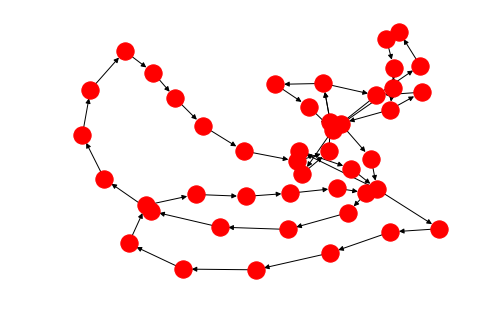

In [26]:
nx.draw(subgraph1)

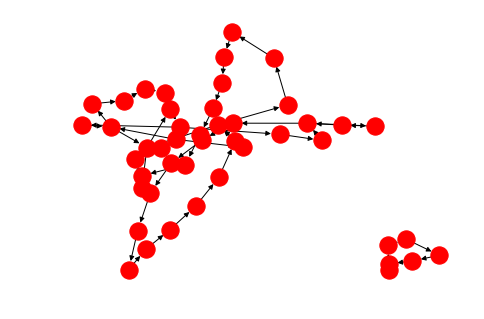

In [17]:
nx.draw(subgraph2)

In [18]:
subgraphs1_sub = [nx.induced_subgraph(subgraph1, s) for s in nx.strongly_connected_components(subgraph1)]
for subgraph in subgraphs1_sub:
    p1 = []
    p2 = []
    for edge in nx.eulerian_circuit(subgraph):
        if ag.idx_to_node[edge[1]] != 0 and ag.idx_to_node[edge[1]] != 1:
            p1.append(ag.idx_to_node[edge[1]][0])
            p2.append(ag.idx_to_node[edge[1]][1])    

    s1 = ""
    for i in range(len(p1)-1):
        e1 = (p1[i], p1[i+1])
        if e1 not in g1.edge_labels:
            s1 += "-"
        else:
            s1 += (g1.edge_labels[e1])
    s2 = ""
    for i in range(len(p2)-1):
        e2 = (p2[i], p2[i+1])
        if e2 not in g2.edge_labels:
            s2 += "-"
        else:
            s2 += g2.edge_labels[e2]

    print(Levenshtein.distance(s1, s2))
    print(s1)
    print(s2)

14
GAB-BBDDDBBBTACTGGAGTCTCCCCAGATCACACAAGACCCAGGACAAAt#
GATACTGGABBB-DDDBBBGTCTCCCCAGATCACACAAGACCCAGGACAAAt#


In [19]:
subgraphs2_sub = [nx.induced_subgraph(subgraph2, s) for s in nx.strongly_connected_components(subgraph2)]

In [20]:
for subgraph in subgraphs2_sub:
    p1 = []
    p2 = []
    for edge in nx.eulerian_circuit(subgraph):
        if ag.idx_to_node[edge[1]] != 0 and ag.idx_to_node[edge[1]] != 1:
            p1.append(ag.idx_to_node[edge[1]][0])
            p2.append(ag.idx_to_node[edge[1]][1])    

    s1 = ""
    for i in range(len(p1)-1):
        e1 = (p1[i], p1[i+1])
        if e1 not in g1.edge_labels:
            s1 += "-"
        else:
            s1 += (g1.edge_labels[e1])
    s2 = ""
    for i in range(len(p2)-1):
        e2 = (p2[i], p2[i+1])
        if e2 not in g2.edge_labels:
            s2 += "-"
        else:
            s2 += g2.edge_labels[e2]

    print(Levenshtein.distance(s1, s2))
    print(s1)
    print(s2)

6
GABBBTACTGGA---GTCTCCCCAGATCACACAAGACCCAGGACAAAt#
GA---TACTGGABBBGTCTCCCCAGATCACACAAGACCCAGGACAAAt#
0
DDBBB
DDBBB


D
D
D
D
D
B
B
B
B
B
B
B
B


D
D
D
D
D
B
B
B
B
B
B
B
B


In [157]:
subgraph2.out_edges

OutEdgeView([(0, 244), (0, 14763), (244, 366), (122, 0), (366, 488), (488, 610), (610, 732), (732, 854), (854, 976), (854, 1098), (976, 5124), (1098, 1220), (1098, 1342), (5124, 5246), (5124, 5368), (1220, 3294), (1342, 1464), (3294, 3416), (3294, 3538), (1296, 10493), (10493, 10615), (1464, 1586), (1586, 1708), (1586, 1830), (1708, 14517), (1830, 1952), (1830, 2074), (1830, 2196), (14517, 14639), (1952, 6466), (1952, 6588), (1952, 6710), (2074, 2318), (2074, 2440), (2074, 2562), (2196, 122), (6466, 12565), (6588, 6830), (6710, 5490), (6710, 5734), (2318, 9755), (2318, 4148), (2440, 13663), (2562, 2684), (2562, 2806), (9755, 9877), (9755, 9999), (4148, 4270), (4148, 4392), (13663, 13785), (2684, 6710), (2806, 2928), (2806, 3050), (2928, 13175), (3050, 3172), (13175, 13297), (3172, 3294), (3416, 13053), (3538, 3660), (13053, 1952), (3660, 3782), (3782, 3904), (3782, 4026), (3904, 12809), (4026, 4148), (12809, 12931), (4270, 4758), (4270, 4880), (4392, 4514), (4758, 6222), (4758, 4758), 

In [77]:
g2.adj_list[16][16]

15

'R531984'

In [112]:
ag.idx_to_node[169]

(1, 16)

In [111]:
ag.idx_to_edge[538]

(169, 169, 1, 15)

In [124]:
xx = []
for cons in model1.getConstrs():
    if cons.rhs == 15:
        c = model1.getRow(cons)
        ss = ""
        sumx = 0
        for i in range(c.size()):
            ss += str(c.getCoeff(i)) + c.getVar(i).VarName + " + "
            xidx = int(c.getVar(i).VarName.lstrip("x[").rstrip("]"))
            n1, n2, cost, w = ag.idx_to_edge[xidx]
            u1,u2 = ag.idx_to_node[n1]
            v1,v2 = ag.idx_to_node[n2]
            if u2 == v2 and u2 == 16:
                if xidx in xs2:
                    sumx += xs2[xidx]
                    print(i,u1,v1,u2,v2,xs2[xidx])
                    xx.append(xidx)
#         print(sumx)
#         print(ss)

33 64 64 16 16 15.0
141 64 64 16 16 15.0


In [119]:
sumx

15.0

In [118]:
xx

[34280, 34280]

In [121]:
xs2[34280]

15.0

## later

In [21]:
g1 = Graph(fname=data_dir+"test_graph1.gfa")
g2 = Graph(fname=data_dir+"test_graph2.gfa")

start = time.time()
ag = Alignment_Graph(g1, g2)

time1 = time.time() - start
start = time.time()

model1 = GTED_ilp(ag, g1, g2, "test.lp", True)

time2 = time.time() - start

gted = model.getObjective().getValue()

start = time.time()        
model2 = CCTED_ilp(ag, g1, g2, "test.lp", True)
time3 = time.time() - start

ccted = model.getObjective().getValue()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 44 physical cores, 88 logical processors, using up to 32 threads
Optimize a model with 822 rows, 378 columns and 1899 nonzeros
Model fingerprint: 0x6e79486c
Variable types: 0 continuous, 378 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 640 rows and 140 columns
Presolve time: 0.00s
Presolved: 182 rows, 238 columns, 1011 nonzeros
Variable types: 0 continuous, 238 integer (121 binary)
Found heuristic solution: objective 12.0000000
Found heuristic solution: objective 10.0000000

Root relaxation: objective 4.761905e-02, 107 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.04762    0    4   10.00000    0.04762   100%     -    0s

In [20]:
for d in model1.getVars():
    if "d" in d.VarName and d.x != 0:
        eid = int(d.VarName.lstrip("d[").rstrip("]"))
        print(ag.idx_to_edge[eid])
        print(d)
        
    if "x" in d.VarName and d.x != 0:
        eid = int(d.VarName.lstrip("x[").rstrip("]"))
        print(ag.idx_to_edge[eid])
        print(d)
        
    if "y" in d.VarName and d.x != 0:
        eid = int(d.VarName.lstrip("y[").rstrip("]"))
        print(ag.idx_to_edge[eid])
        print(d)

(0, 6, 0, 1)
<gurobi.Var x[2] (value 1.0)>
(6, 12, 0, 1)
<gurobi.Var x[23] (value 1.0)>
(8, 19, 0, 1)
<gurobi.Var x[50] (value 1.0)>
(12, 0, 0, 1)
<gurobi.Var x[62] (value 1.0)>
(19, 22, 0, 1)
<gurobi.Var x[89] (value 1.0)>
(22, 8, 0, 1)
<gurobi.Var x[101] (value 1.0)>
(25, 0, 0, 1)
<gurobi.Var x[108] (value 1.0)>
(0, 26, 0, 1)
<gurobi.Var x[109] (value 1.0)>
(6, 11, 1, 1)
<gurobi.Var d[21] (value 1.0)>
(7, 12, 1, 1)
<gurobi.Var d[24] (value 2.0)>
(8, 13, 1, 1)
<gurobi.Var d[30] (value 1.0)>
(11, 2, 1, 1)
<gurobi.Var d[59] (value 1.0)>
(12, 2, 1, 1)
<gurobi.Var d[60] (value 3.0)>
(13, 4, 1, 1)
<gurobi.Var d[68] (value 1.0)>
(19, 22, 0, 1)
<gurobi.Var d[89] (value 1.0)>
(22, 7, 1, 1)
<gurobi.Var d[96] (value 2.0)>
(25, 0, 0, 1)
<gurobi.Var d[108] (value 1.0)>
(0, 26, 0, 1)
<gurobi.Var d[109] (value 3.0)>
(2, 26, 0, 1)
<gurobi.Var d[121] (value 4.0)>
(4, 26, 0, 1)
<gurobi.Var d[125] (value 1.0)>
(0, 5, 1, 1)
<gurobi.Var y[0] (value 1.0)>
(0, 1, 1, 1)
<gurobi.Var y[1] (value 1.0)>
(0, 6, 

In [168]:

for i in range(length):
    if random.choice(10) <= mut_rate:
        print(True)

True
True
True
